# Testing Notebook

## Imports

In [1]:
# %load ~/dev/marthaler/header.py
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from dataclasses import dataclass
from typing import Dict, Any, Tuple
from datetime import datetime, timedelta

import warnings

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rc('figure', figsize=(16, 10))
plt.rc('font', size=14)


In [2]:
import jax.numpy as jnp
from jax import vmap, grad, jit
import equinox as eqx
import jax

In [3]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


## Functions

In [4]:
def shift_image(
    img: np.ndarray[np.uint8],
    horizontal_shift: int,
    vertical_shift: int,
)->np.ndarray[np.uint8]:
    """
      Function to shift an image by fixed numbers of pixels and fill in with 0.
      
      The image origin in numpy are at the top-left corner so to get a positive
      vertical shift, we need to negate the vertical shift value passed in.
      
      :param img: The input image
      :type img: np.ndarray[np.uint8]
      :param horizontal_shift: the number of pixels to shift horizontally
      :type horizontal_shift: int
      :param vertical_shift: the number of pixels to shift vertically
      :type vertical_shift: int
      :return: The shifted image
      :rtype: np.ndarray[np.uint8]
    """
    # Negate the vertical shift to compensate for the origin at the top-left of image
    vertical_shift = -vertical_shift
    shift_img = np.roll(img, vertical_shift, axis=0)
    shift_img = np.roll(shift_img, horizontal_shift, axis=1)
    if vertical_shift>0:
        shift_img[:vertical_shift, :] = 0
    elif vertical_shift<0:
        shift_img[vertical_shift:, :] = 0
    if horizontal_shift>0:
        shift_img[:, :horizontal_shift] = 0
    elif horizontal_shift<0:
        shift_img[:, horizontal_shift:] = 0
    return shift_img

In [5]:
from typing import Sequence, Union
class BasicConv2d(eqx.Module):
    act_norm: bool
    conv: Union[eqx.nn.ConvTranspose,eqx.nn.Conv]
    #norm: eqx.nn.GroupNorm
    #activation: jax.nn.leaky_relu
    #negative_slope: float=0.2

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[int, Sequence[int]],
        stride: Union[int, Sequence[int]],
        padding: Union[str, int, Sequence[int]],
        key: jax.random.PRNGKey,
        transpose: bool=False,
        act_norm: bool=False,
    )->None:
        super(BasicConv2d, self).__init__()
        self.act_norm = act_norm
        if transpose:
            self.conv = eqx.nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                output_padding=stride // 2,
                key = key,
            )
        else:
            self.conv = eqx.nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                key = key,
            )
            
        #self.norm = eqx.nn.GroupNorm(groups=1, channels=out_channels)
        #self.activation = jax.nn.leaky_relu
        
    def __call__(self, x):
        y = self.conv(x)
        #if self.act_norm:
        #    y = self.activation(self.norm(y),negative_slope=self.negative_slope)
        return y

class ConvSC(eqx.Module):
    conv: Union[eqx.nn.ConvTranspose,eqx.nn.Conv]
    def __init__(
        self,
        C_in: int,
        C_out: int,
        stride: Union[int, Sequence[int]],
        key: jax.random.PRNGKey,
        transpose: bool=False,
        act_norm: bool=True
    )->None:
        super(ConvSC, self).__init__()
        if stride == 1:
            transpose = False
        self.conv = BasicConv2d(
            C_in,
            C_out,
            kernel_size=3,
            stride=stride,
            padding=1,
            key=key,
            transpose=transpose,
            act_norm=act_norm,
        )

    def __call__(self, x):
        y = self.conv(x)
        return y

In [6]:
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping

class Encoder(eqx.Module):
    enc: list

    def __init__(
        self,
        num_channels: int,
        num_features: int,
        num_layers: int,
        key: jax.random.PRNGKey
    )->None:
        super(Encoder, self).__init__()
        keys = jax.random.split(key, num_layers)
        self.enc = [
            eqx.nn.Conv2d(num_channels, num_features, kernel_size=3, stride=2, padding=1, key=keys[0])
        ]
        for i in range(1,num_layers):
            self.enc.append(eqx.nn.Conv2d(num_features, num_features, kernel_size=3, stride=2, padding=1, key=keys[i]))

    def __call__(self, x: Float[Array, "1 64 64"])->Float[Array, "1 16 16"]:
        latent = self.enc[0](x)
        for i in range(1, len(self.enc)):
            latent = self.enc[i](latent)
        return latent

In [33]:
class Decoder(eqx.Module):
    readout: eqx.nn.Conv2d
    dec: list

    def __init__(
        self,
        num_features: int,
        num_out_features: int,
        num_layers: int,
        key: jax.random.PRNGKey
    )->None:
        super(Decoder, self).__init__()
        keys = jax.random.split(key, num_layers+1)
        self.dec = [
            eqx.nn.ConvTranspose2d(num_features, num_features, kernel_size=3, key=key, stride=2, padding=1, output_padding=1)
        ]
        for i in range(1,num_layers-1):
            self.dec.append(eqx.nn.ConvTranspose2d(num_features, num_features, kernel_size=3, stride=2, key=keys[i], padding=1, output_padding=1))

        self.readout = eqx.nn.ConvTranspose2d(num_features, num_out_features,kernel_size=3, stride=2, key=keys[-1], padding=1, output_padding=1)

    def __call__(self, hid, enc1=None):
        for i in range(0, len(self.dec)):
            hid = self.dec[i](hid)
        return self.readout(hid)

In [55]:
class SimVP(eqx.Module):
    enc: Encoder
    dec: Decoder
    def __init__(
        self,
        shape_in,
        key: jax.random.PRNGKey,
        hid_S: int=16,
        num_layers: int=4,
    ):
        #key1, key2 = jax.random.split(key, 2)
        super(SimVP, self).__init__()
        T, C, H, W = shape_in
        keys = jax.random.split(key, 2)
        self.enc = Encoder(C, hid_S, num_layers, keys[0])
        self.dec = Decoder(hid_S, C, num_layers, keys[1])
#         cnn = eqx.Conv(...)
#         cnn_t = eqx.ConvTranspose(...)
#         cnn_t = eqx.tree_at(lambda x: x.weight, cnn_t, jnp.flip(cnn.weight,
#                             axis=tuple(range(2, cnn.weight.ndim))).swapaxes(0, 1))


    def __call__(self, x_raw):
        B, T, C, H, W = x_raw.shape
        x = x_raw.reshape(B*T, C, H, W)

        embed = vmap(self.enc)(x)
        return vmap(self.dec)(embed).reshape(B, T, C, H, W)

## Load Image Data

In [9]:
imgs = np.load('/Users/daniel.marthaler/dev/SimVP/data/moving_mnist/mnist_test_seq.npy')

In [10]:
imgs.shape

(20, 10000, 64, 64)

In [11]:
type(imgs[0,0,:,:]), type(imgs[0,0,0,0])

(numpy.ndarray, numpy.uint8)

In [12]:
#plt.imshow(imgs[0,0,:,:]);

In [13]:
# Shift image
#plt.imshow(shift_image(imgs[0,0,:,:],-20,10));

## Parameters

In [14]:
seed = 42
batch_size = 16
val_batch_size=16
num_workers=8

# model parameters
in_shape=[10, 1, 64, 64]  
hid_S=64
hid_T=256
num_layers=3
N_T=8
groups=4

# Training parameters
epochs=1000
log_step=1
lr=0.01

## Model

In [15]:
from dataloader_moving_mnist import load_data

In [16]:
train_loader, vali_loader, test_loader, data_mean, data_std = load_data(
    batch_size,
    val_batch_size,
    '/Users/daniel.marthaler/dev/SimVP/data',
    num_workers
)

In [17]:
for batch_x, batch_y in train_loader:
    break

In [18]:
x_raw = batch_x.numpy()
y_raw = batch_y.numpy()

In [19]:
x_raw.shape

(16, 10, 1, 64, 64)

In [49]:
key = jax.random.PRNGKey(seed)
model = SimVP(tuple(in_shape), key, hid_S, num_layers)

In [50]:
y_pred = model(x_raw)

In [51]:
y_pred.shape, x_raw.shape

((16, 10, 1, 64, 64), (16, 10, 1, 64, 64))

In [52]:
np.allclose(y_pred,x_raw)

False

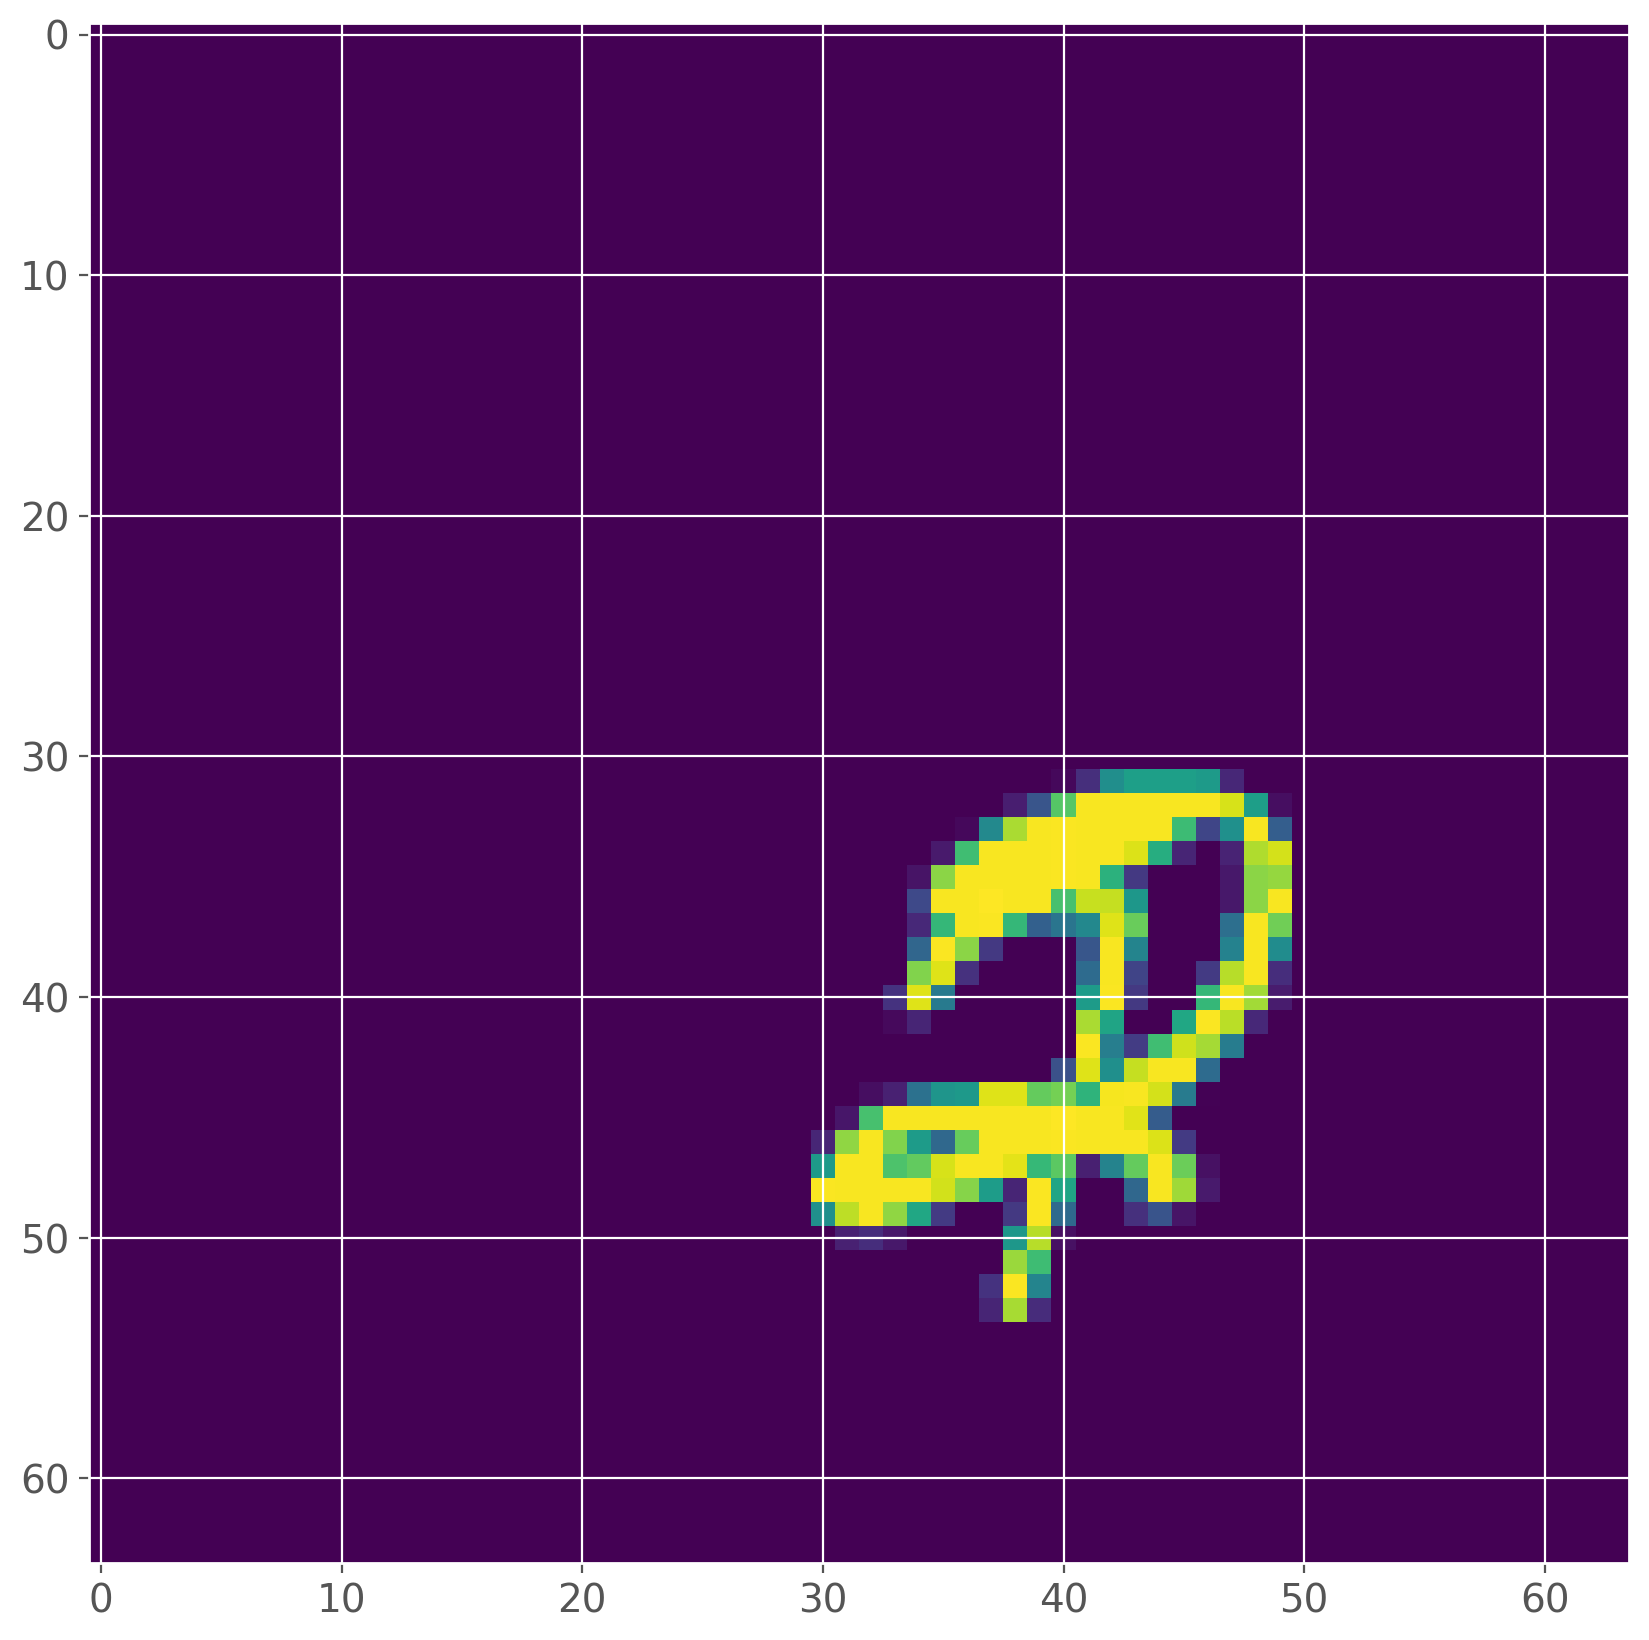

In [53]:
plt.imshow(x_raw[0,0,0,:,:])

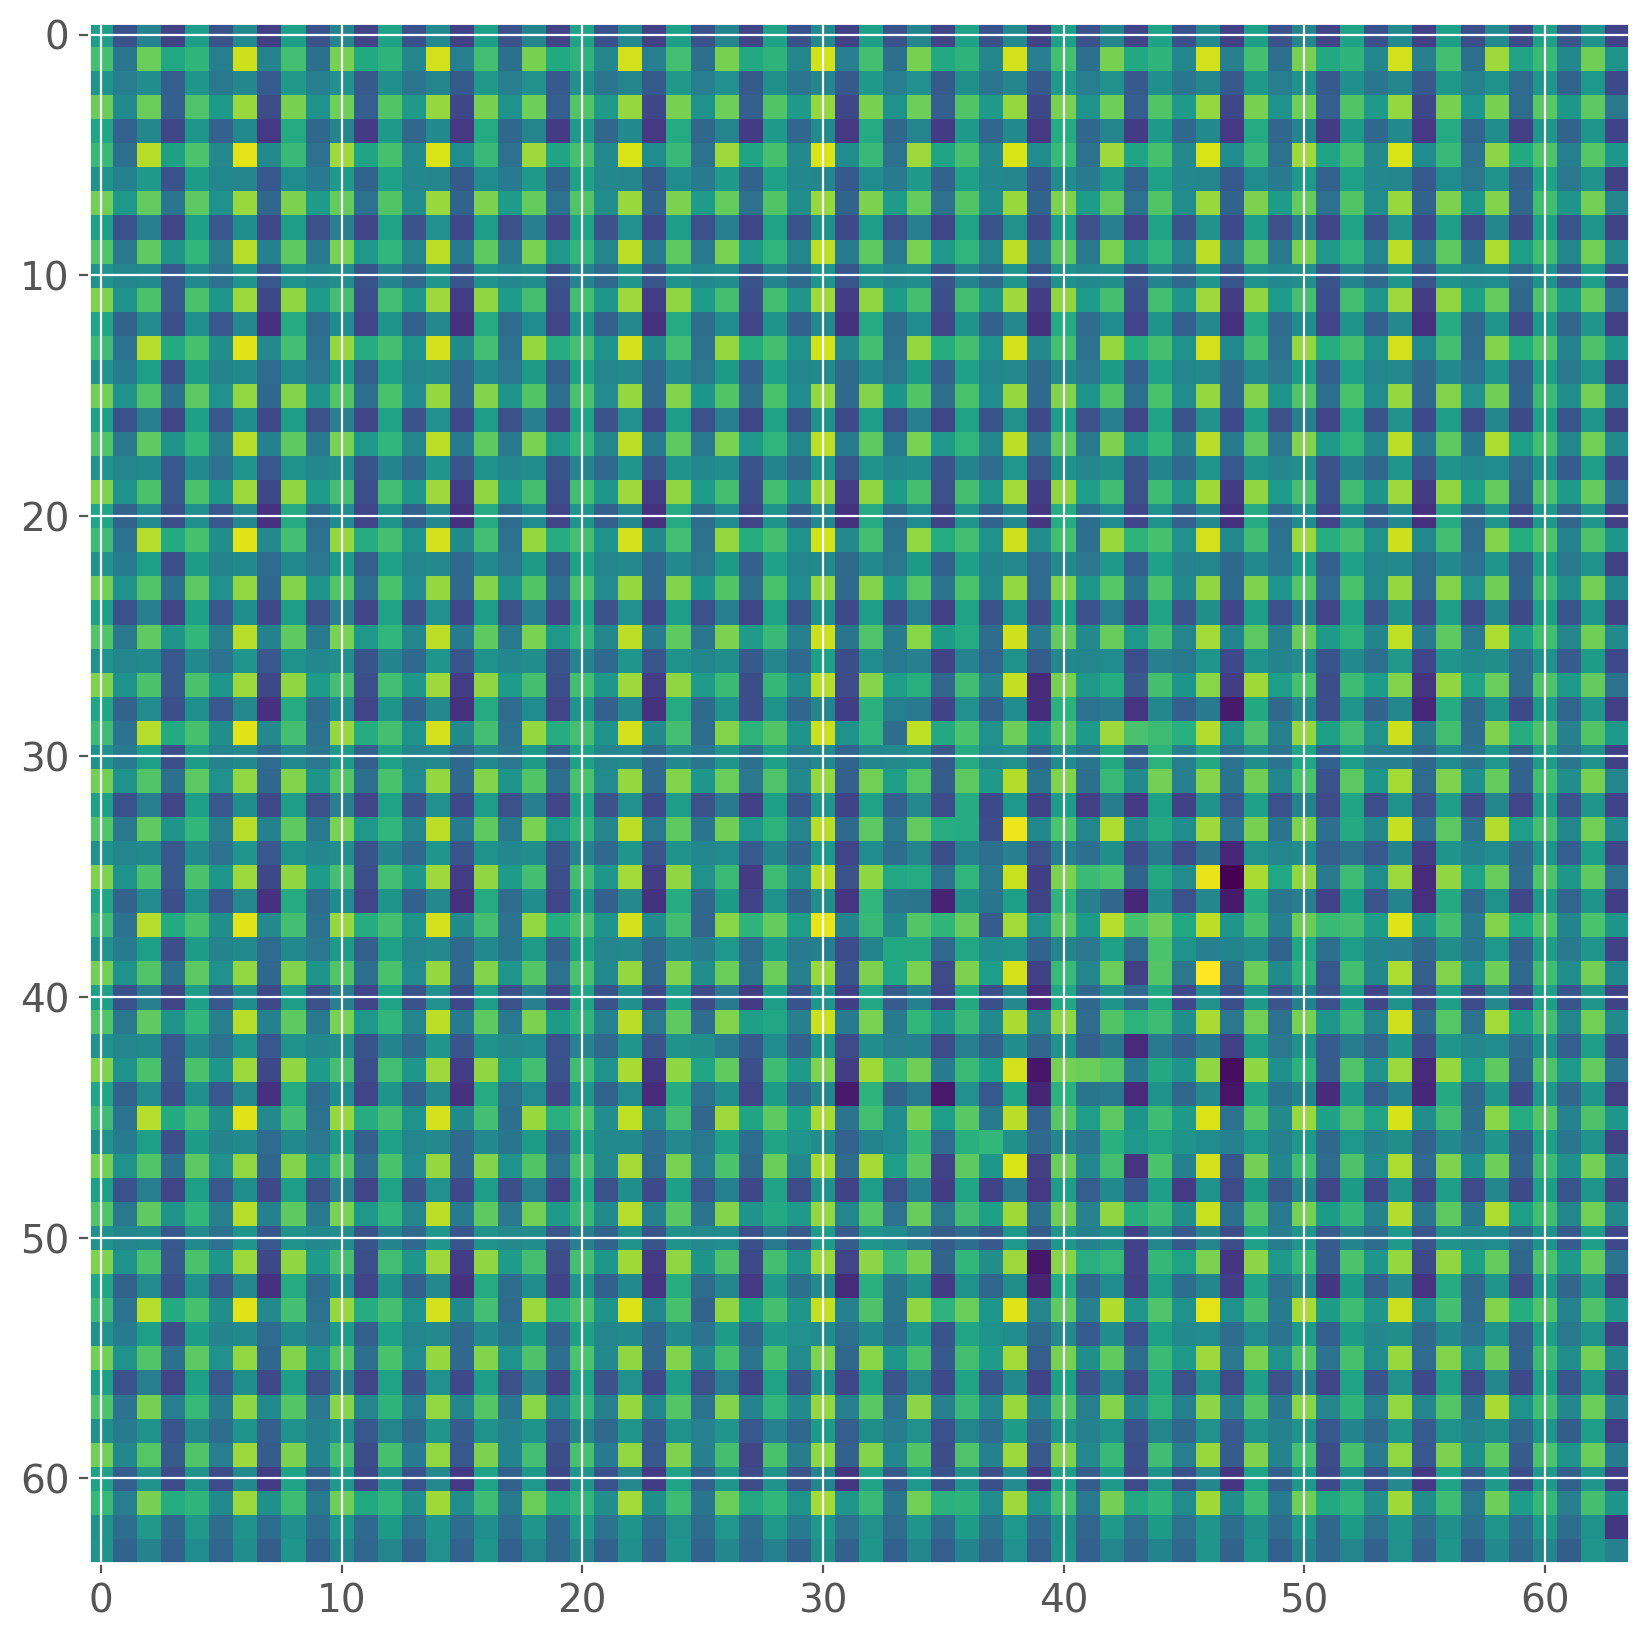

In [54]:
plt.imshow(y_pred[0,0,0,:,:])